## Debiasing Importance Sampling

We consider a toy self-normalized importance sampling setup, and a technique to remove the bias from the standard importance sampling estimator.

In [4]:
# import package
using Random, Distributions, Plots, QuadGK, PrettyTables
# set seed
Random.seed!(123);
println(Threads.nthreads())

12


Define target and proposal:

- target is a mixture of Normals:
$0.2\text{Normal}(-1,1.2) +  0.5\text{Normal}(0, 1) + 0.3\text{Normal}(3, 2.5)$,

- proposal is a centered t-distribution with scale 2 and 3 degrees of freedom.

The following plots the probability density functions of the <span style='color: DarkOrange'>target</span> and of the <span style='color: navy'>proposal</span>.

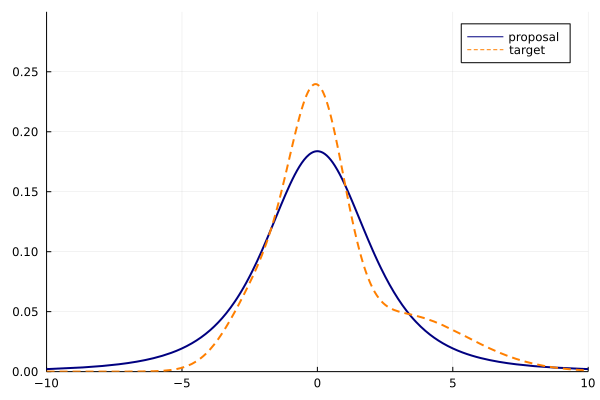

In [2]:
# define proposal
TDist2(μ, σ, ν) = μ + σ*TDist(ν)
proposal = TDist2(0, 2, 3)
# define target
target = MixtureModel(Normal[
   Normal(-2.0, 1.2), Normal(0.0, 1.0), Normal(3.0, 2.5)], [0.2, 0.5, 0.3])
# plot densities
xgrid = 0:0.1:16; yvalues = pdf.(proposal, xgrid);
q(x) = pdf.(proposal,x)
pi(x) = pdf.(target,x)
plot(xlims = (-10, 10), ylims = (0, .3))
plot!(q, seriescolor=:navy, legend=true, linewidth=2, label = "proposal")
plot!(pi,seriescolor=:darkorange1,linewidth=2,linestyle=:dash, label = "target")

### Ground truth

We consider the problem of computing the integral: $\int h(x) \pi(dx)$, with $h(x)= x^2 \cos(x)$.
In the current setup, we can do it precisely using adaptive Gauss-Kronrod quadrature. This gives a "ground truth" for the following experiments.

In [5]:
h(x) = cos(x)*x^2
integrand(x) = h.(x)*pdf.(target, x)
integral = quadgk(integrand, -Inf, Inf, rtol=1e-5)
qoi = integral[1]
println("estimated integral of interest: ", round(qoi; digits = 4))
println("estimated upper bound on the error: ", round(integral[2]; digits = 8))

estimated integral of interest: -0.4053
estimated upper bound on the error: 2.79e-6


### Standard importance sampling

First, estimate the quantity of interest by importance sampling from the proposal distribution $q$. $N$ denotes the number of draws.

In [26]:
# compute log-weight
function weight(x)
    logw = logpdf.(target, x) .- logpdf.(proposal, x)
    return logw
end
# importance sampling (self-normalized) with N draws
# returns x values, weights, and estimate of normalizing constant
function is(N)
    x = rand(proposal, N)
    logw = weight(x)
    maxlogw = maximum(logw)
    w = exp.(logw .- maxlogw)
    logavew = maxlogw + log(mean(w))
    nw = w ./ sum(w)
    return Dict("x" => x, "nw" => nw, "logavew" => logavew)
end
# importance sampling estimation of \int h(x) \pi(dx)
N = 1000000
is_result = is(N)
is_estimate = sum(h.(is_result["x"]) .* is_result["nw"])
is_var = sum(is_result["nw"].^2 .* (h.(is_result["x"]) .- is_estimate).^2)
is_low = is_estimate-1.96*sqrt(is_var)
is_high = is_estimate+1.96*sqrt(is_var)
println("IS estimate: ", round(is_estimate;digits=4), ", using N = ", N, " draws")
println("95% CLT-based confidence interval: [", round(is_low; digits=4),", ", round(is_high; digits=4), "]")
println("ground truth: ", round(qoi; digits = 4))

IS estimate: -0.419, using N = 1000000 draws
95% CLT-based confidence interval: [-0.4409, -0.3971]
ground truth: -0.4053


We compute the "inefficiency" (lower is better!), defined as the product of the asymptotic variance times the cost of the estimator, see

* [GW1992] Glynn & Whitt, _[The asymptotic efficiency of simulation estimators](https://pubsonline.informs.org/doi/abs/10.1287/opre.40.3.505)_, 1992.

In [27]:
is_inefficiency = is_var * N
println("IS asymptotic inefficiency: ", round(is_inefficiency; digits = 2))

IS asymptotic inefficiency: 125.25


Below we compute the bias and variance for various small values $N$, using many independent replications.

In [35]:
nrep = 100000
Nseq = [2, 4, 8, 16, 32, 64]
bias = zeros(length(Nseq))
variance = zeros(length(Nseq))
for iN in 1:length(Nseq)
    is_estimates = zeros(nrep)
    Threads.@threads for irep in 1:nrep
        is_result = is(Nseq[iN])
        is_estimates[irep] = sum(h.(is_result["x"]) .* is_result["nw"])
    end
    bias[iN] = mean(is_estimates) - qoi
    variance[iN] = var(is_estimates)
end

data = hcat(Nseq, bias, bias.^2, variance)
header = (["N", "bias", "squared bias", "variance"])
pretty_table(data; header = header, formatters = (ft_printf("%1u", 1),ft_printf("%5.2f", 2:4)), compact_printing = true)

┌────┬───────┬──────────────┬──────────┐
│  N │  bias │ squared bias │ variance │
├────┼───────┼──────────────┼──────────┤
│  2 │ -0.67 │         0.45 │    59.06 │
│  4 │ -0.38 │         0.14 │    25.63 │
│  8 │ -0.18 │         0.03 │    14.19 │
│ 16 │ -0.10 │         0.01 │     7.50 │
│ 32 │ -0.05 │         0.00 │     3.85 │
│ 64 │ -0.02 │         0.00 │     1.94 │
└────┴───────┴──────────────┴──────────┘


The squared bias is very small compared to the variance, but it is noticeable for very small $N$.

### Debiasing importance sampling

Now we look at removing the bias of self-normalized importance sampling completely.
The idea is to embed importance sampling in particle MCMC, see

* [ADH2010] Andrieu, Doucet & Holenstein, _[Particle Markov chain Monte Carlo methods](https://rss.onlinelibrary.wiley.com/doi/full/10.1111/j.1467-9868.2009.00736.x)_, 2010.

Then one can apply the debiasing technique pioneered in

* [GR2014] Glynn & Rhee, _[Exact estimation for Markov chain equilibrium expectations](https://www.cambridge.org/core/journals/journal-of-applied-probability/article/exact-estimation-for-markov-chain-equilibrium-expectations/844D4F8B0872C8516FE8B51B2BAA103B)_, 2014.

The technique implemented below to debias importance sampling is described in 

* [MDDJ2019] Middleton, Deligiannidis, Doucet & Jacob,
_[Unbiased Smoothing using Particle Independent Metropolis-Hastings](http://proceedings.mlr.press/v89/middleton19a.html)_, 2019.

We'll call that "method 1".

In [9]:
function method1(N)
    estimate = 0.
    state1 = is(N)
    estimate += sum(state1["nw"] .* h.(state1["x"]))
    state2 = is(N)
    tau = +Inf
    u = rand()
    if (log(u) < (state2["logavew"] - state1["logavew"]))
        tau = 1
    end
    time = 1
    while isinf(tau)
        estimate += sum(state1["nw"] .* h.(state1["x"])) - sum(state2["nw"] .* h.(state2["x"])) 
        time += 1
        stateproposal = is(N)
        u = rand()
        logacc1 = (stateproposal["logavew"] - state1["logavew"])
        logacc2 = (stateproposal["logavew"] - state2["logavew"])
        if (log(u) < logacc1)
            state1 = stateproposal
        end
        if (log(u) < logacc2)
            state2 = stateproposal
        end
        if (log(u) < logacc1) & (log(u) < logacc2)
            tau = time
        end
    end
    return Dict("estimate" => estimate, "tau" => tau)
end

method1 (generic function with 1 method)

The approach is pretty much exactly that described in GR2014, in the case of Metropolis-Rosenbluth-Teller-Hastings algorithms with independent proposals. The coupling consists simply in proposing the same values to both chains. The twist in MDDJ2019 is in the initialization, where the second chain's initial state is employed as a proposal in the first chain's first iteration. This enables the possibility of meeting at time 1, whereas the construction of GR2014 would result in a meeting time equal to at least 2.

The algorithm is applicable wherever importance sampling is applicable: it is a "meta-algorithm" that encapsulates importance sampling within a debiasing technique.

Below we see how it performs, for various choices of $N$.

In [34]:
# compute bias, variance, mean "meeting time", mean cost
bias_dis1 = zeros(length(Nseq))
variance_dis1 = zeros(length(Nseq))
meantau_dis1 = zeros(length(Nseq))
meancost_dis1 = zeros(length(Nseq))
estimates_dis1 = zeros(nrep)
taus_dis1 = zeros(nrep)
cost_dis1 = zeros(nrep)
# for each N
for iN in 1:length(Nseq)
    N = Nseq[iN]
    # for each repeat
    Threads.@threads for irep in 1:nrep
        # run algorithm
        dis_result = method1(N)
        estimates_dis1[irep] = dis_result["estimate"]
        taus_dis1[irep] = dis_result["tau"]
        cost_dis1[irep] = 2*N + (taus_dis1[irep]-1)*N
    end
    # compute bias, variance, mean "meeting time", mean cost
    bias_dis1[iN] = mean(estimates_dis1) - qoi
    variance_dis1[iN] = var(estimates_dis1)
    meantau_dis1[iN] = mean(taus_dis1)
    meancost_dis1[iN] = mean(cost_dis1)
end
# print results
data = hcat(Nseq, bias_dis1, bias_dis1.^2, variance_dis1, meantau_dis1, meancost_dis1, meancost_dis1 .* variance_dis1)
header = (["N", "bias", "squared bias", "variance", "mean tau", "mean cost", "inefficiency"])
pretty_table(data; header = header, formatters = (ft_printf("%1u", 1),ft_printf("%5.2f", 2:7)), compact_printing = true)

┌────┬───────┬──────────────┬──────────┬──────────┬───────────┬──────────────┐
│  N │  bias │ squared bias │ variance │ mean tau │ mean cost │ inefficiency │
├────┼───────┼──────────────┼──────────┼──────────┼───────────┼──────────────┤
│  2 │  0.01 │         0.00 │   113.56 │     1.15 │      4.29 │       487.66 │
│  4 │ -0.00 │         0.00 │    44.22 │     1.11 │      8.43 │       372.60 │
│  8 │  0.01 │         0.00 │    20.77 │     1.08 │     16.60 │       344.75 │
│ 16 │ -0.00 │         0.00 │     9.60 │     1.05 │     32.81 │       314.98 │
│ 32 │  0.00 │         0.00 │     4.60 │     1.04 │     65.15 │       299.51 │
│ 64 │ -0.00 │         0.00 │     2.19 │     1.03 │    129.65 │       283.37 │
└────┴───────┴──────────────┴──────────┴──────────┴───────────┴──────────────┘


We see that the bias is indeed removed, with small deviations from zero observed due to Monte Carlo errors. We also see that the "inefficiency" (=variance * mean cost) is larger than with importance sampling, but the difference is not crazy. In fact, as $N\to\infty$ the inefficiency of method 1 compared to importance sampling would be two-fold.

### More efficient version

Below is a slight variation of method 1 where we "Rao-Blackwellize" the order of the two initial states of the chains, i.e. we consider two runs of method 1 with the initial states swapped. That is, we propose the second chain's initial state in the first chain's first transition, and we propose the first chain's initial state in the second chain's first transition. At least one of these proposals will be accepted resulting in a meeting at time one. The procedure continues until the second meeting is reached. The output is the average of the output of the two runs.

We'll call that "method 2".

Method 2 yields a two-fold improvement in efficiency over method 1 as $N\to \infty$. Intuitively, since both methods start by running IS twice independently, method 2 is more efficient because the final estimate employs both IS runs and not only one as in method 1. 



In [31]:
function method2(N)
    estimate = 0.
    state1 = is(N)
    state2 = is(N)
    if (state1["logavew"] < state2["logavew"])
        swap = state2
        state2 = state1
        state1 = swap
    end
    estimate1 = sum(state1["nw"] .* h.(state1["x"]))
    estimate2 = sum(state2["nw"] .* h.(state2["x"]))
    tau = +Inf
    u = rand()
    if (log(u) < (state2["logavew"] - state1["logavew"]))
        tau = 1
    end
    time = 1
    while isinf(tau)
        estimate1 += sum(state1["nw"] .* h.(state1["x"])) - sum(state2["nw"] .* h.(state2["x"]))
        time += 1
        stateproposal = is(N)
        u = rand()
        logacc1 = (stateproposal["logavew"] - state1["logavew"])
        logacc2 = (stateproposal["logavew"] - state2["logavew"])
        if (log(u) < logacc1)
            state1 = stateproposal
        end
        if (log(u) < logacc2)
            state2 = stateproposal
        end
        if (log(u) < logacc1) & (log(u) < logacc2)
            tau = time
        end
    end
    return Dict("estimate" => 0.5*estimate1+0.5*estimate2, "tau" => tau)
end

method2 (generic function with 1 method)

In [36]:
# compute bias, variance, mean "meeting time", mean cost
bias_dis2 = zeros(length(Nseq))
variance_dis2 = zeros(length(Nseq))
meantau_dis2 = zeros(length(Nseq))
meancost_dis2 = zeros(length(Nseq))
estimates_dis2 = zeros(nrep)
taus_dis2 = zeros(nrep)
cost_dis2 = zeros(nrep)
# for each N
for iN in 1:length(Nseq)
    N = Nseq[iN]
    # for each repeat
    Threads.@threads for irep in 1:nrep
        # run algorithm
        dis_result = method2(N)
        estimates_dis2[irep] = dis_result["estimate"]
        taus_dis2[irep] = dis_result["tau"]
        cost_dis2[irep] = 2*N + (taus_dis2[irep]-1)*N
    end
    # compute bias, variance, mean "meeting time", mean cost
    bias_dis2[iN] = mean(estimates_dis2) - qoi
    variance_dis2[iN] = var(estimates_dis2)
    meantau_dis2[iN] = mean(taus_dis2)
    meancost_dis2[iN] = mean(cost_dis2)
end
# print results
data = hcat(Nseq, bias_dis2, bias_dis2.^2, variance_dis2, meantau_dis2, meancost_dis2, meancost_dis2 .* variance_dis2)
header = (["N", "bias", "squared bias", "variance", "mean tau", "mean cost", "inefficiency"])
pretty_table(data; header = header, formatters = (ft_printf("%1u", 1),ft_printf("%5.2f", 2:7)), compact_printing = true)

┌────┬───────┬──────────────┬──────────┬──────────┬───────────┬──────────────┐
│  N │  bias │ squared bias │ variance │ mean tau │ mean cost │ inefficiency │
├────┼───────┼──────────────┼──────────┼──────────┼───────────┼──────────────┤
│  2 │ -0.00 │         0.00 │    45.28 │     1.30 │      4.59 │       207.99 │
│  4 │  0.01 │         0.00 │    20.25 │     1.21 │      8.83 │       178.91 │
│  8 │  0.01 │         0.00 │     9.40 │     1.14 │     17.16 │       161.30 │
│ 16 │  0.00 │         0.00 │     4.47 │     1.10 │     33.63 │       150.43 │
│ 32 │  0.00 │         0.00 │     2.15 │     1.07 │     66.36 │       142.79 │
│ 64 │  0.00 │         0.00 │     1.05 │     1.05 │    131.26 │       137.69 │
└────┴───────┴──────────────┴──────────┴──────────┴───────────┴──────────────┘


We see that the cost of each run of method 2 is only slightly larger than the cost of method 1, but the variance is halved, resulting in a smaller inefficiency overall.

#### Alternative debiasing schemes and variance reduction

1. The above estimators are based on the "particle independent Metropolis-Hastings" algorithm, but we can also debias "particle Gibbs" samplers, as was done in 

* JLS2019] Jacob, Lindsten & Schön, _[Smoothing With Couplings of Conditional Particle Filters](https://www.tandfonline.com/doi/abs/10.1080/01621459.2018.1548856?journalCode=uasa20)_, 2019.

* [LSV2020] Lee, Singh & Vihola, _[Coupled conditional backward sampling particle filter](https://projecteuclid.org/journals/annals-of-statistics/volume-48/issue-5/Coupled-conditional-backward-sampling-particle-filter/10.1214/19-AOS1922.short)_, 2020.


2. The above experiments correspond to the $H_{0}$ estimator in 

* [JOA2020] Jacob, O'Leary, Atchadé, _[Unbiased Markov chain Monte Carlo methods with couplings](https://rss.onlinelibrary.wiley.com/doi/full/10.1111/rssb.12336)_, 2020.

That article, also JLS2019 above, and follow-ups since then, introduce further variance reduction techniques ($H_k$, then $H_{k:m}$, then increasing the lag) that could be considered for importance sampling as well.